# Trabalho 5 - Reconhecimento de Padrões

## Importação de bibliotecas e carregamento dos dados

In [1]:
import random

import pandas                         as pd
import numpy                          as np
import seaborn                        as sns
import matplotlib.pyplot              as plt

from sklearn.metrics                  import r2_score
from sklearn.model_selection          import train_test_split

sns.set_style("whitegrid")
%matplotlib inline

In [2]:
#caminho absoluto para os dados
houses_path = os.path.realpath('data/kc_house_data.csv')
aerogerador_path = os.path.realpath('data/aerogerador.dat')

houses = pd.read_csv(houses_path)
aerogerador = pd.read_csv(aerogerador_path, header=None, sep='\t', usecols=[0, 1])

In [3]:
X_houses = houses.drop('price', axis = 1)
y_houses = houses['price']

#Removendo as colunas de identificação e data
X_houses = X_houses.drop(['id', 'date', 'zipcode'], axis = 1)

In [4]:
X_aerogerador = aerogerador[0]
y_aerogerador = aerogerador[1]

## Implementação dos algoritmos

### Regressão Linear Múltipla com regularização Ridge

In [5]:
class RidgeRegression:
    def fit(self, lambda_param):
      self.lambda_param = lambda_param

    def calcula_coeficientes(self, X_test, y_test):
      matriz_reg = pd.DataFrame(X_test).copy()
      lista_colunas = list(matriz_reg.columns)

      #criando a coluna com valores 1 da matriz de regressão 
      matriz_reg['col'] = 1

      #mudando a ordem das colunas
      lista_colunas.insert(0, 'col')
      matriz_reg = matriz_reg[lista_colunas]

      #calculando o vetor de coeficientes pelo métodos de Mínimos Quadrados Ordinários, adicionando a constante de regularização Ridge
      tam_matriz = matriz_reg.shape
      coeficientes = np.dot(np.linalg.inv(np.dot(matriz_reg.T, matriz_reg) + self.lambda_param*np.eye(tam_matriz[1])), np.dot(y_test, matriz_reg))

      return coeficientes

    def predict(self, X_test, y_test):
      coeficientes = self.calcula_coeficientes(X_test, y_test)

      #a regressão múltipla tem o formato B(0) + B(1)X1 + B(2)X2 + ... + B(n)Xn
      y_chap = coeficientes[0] + np.dot(X_test, coeficientes[1:])

      return y_chap

In [6]:
#função auxiliar - r2 ajustado
def r2_ajustado(r2, tamanho_matriz):
  return np.round(1 - (1 - r2) * (tamanho_matriz[0] - 1) / (tamanho_matriz[0] - tamanho_matriz[1] - 1), 6)

### K-fold cross-validation

In [7]:
def kfoldcv(X, y, k, model, lambda_param, normalize = False):
  """
  O cross-validation utilizando k-fold consiste em dividir os dados em
  k partes iguais (ou aproximadamente iguais), para treinar com todos os dados
  
  Nesse método, escolhemos aleatoriamente uma parte do dataset para teste, e
  deixamos o restante para treino.
  """

  tamanho_fold = round(len(X)/k)

  #armazenamos e embaralhamos os índices dos dados para satisfazer a aleatoriedade
  indices = list(range(len(X)))
  random.shuffle(indices)

  #criando os índices dos intervalos de dados de acordo com o tamanho de cada fold
  folds = [indices[x:x+tamanho_fold] for x in range(0, len(indices), tamanho_fold)]

  lista_r2aj = list()

  for i in range(k):
    indices_teste = folds[i]
    X_teste = X.iloc[indices_teste, :]
    y_teste = y.iloc[indices_teste]

    indices_treino = []
    for fold in folds:
      if fold != indices_teste:
        indices_treino.append(fold)

    #transformando a lista de listas em uma lista só
    indices_treino = [item for outer_list in indices_treino for item in outer_list]
    X_treino = X.iloc[indices_treino, :]
    y_treino = y.iloc[indices_treino]

    #normalização dos dados usando z-score, caso seja solicitado
    if normalize:
      X_treino = (X_treino - np.mean(X_treino))/np.std(X_treino)
      X_teste = (X_teste - np.mean(X_treino))/np.std(X_treino)

    #coletando os valores calculados pelo modelo
    model.fit(lambda_param)
    preds = model.predict(X_teste, y_teste)

    #calculando os coeficientes do modelo
    coeficientes = model.calcula_coeficientes(X_teste, y_teste)

    #calculando o R2, que mede o quão bem o modelo explica a variabilidade dos dados
    #para a regressão múltipla, sempre que adicionamos uma variável o R2 aumenta.
    #para corrigir esse viés, usamos o R2 ajustado
    r2 = np.round(r2_score(y_teste, preds), 4)
    r2aj = r2_ajustado(r2, np.matrix(X_teste).shape)
    lista_r2aj.append(r2aj)
    
    print(f"\n\n{'-' * 40} MODELO {i+1} {'-' * 40}")
    print(f'\nCoeficientes: \n{coeficientes}')  
    print(f'\nR2 ajustado: {r2aj}\n')

    #plotando um gráfico que mostra a relação entre os valores reais e os valores preditos pelo modelo
    plt.figure(figsize=(10,10))
    plt.scatter(y_teste, preds, c='crimson')

    plt.title(f'Relação entre os valores reais e as predições - Modelo {i+1}', fontsize = 15)
    plt.xlabel('Valores reais', fontsize=12)
    plt.ylabel('Predições', fontsize=12)
    plt.axis('equal')
    plt.show()

  return lista_r2aj

### Regressão Polinomial com regularização Ridge

In [8]:
class PolynomialRegression:
    def fit(self, degree, lambda_param):
      self.degree = degree
      self.lambda_param = lambda_param

    def calcula_coeficientes(self, X_test, y_test):
      matriz_reg = pd.DataFrame(X_test).copy()
      lista_colunas = list(matriz_reg.columns)

      #criando a coluna com valores 1 da matriz de regressão 
      matriz_reg['col'] = 1

      #mudando a ordem das colunas
      lista_colunas.insert(0, 'col')
      matriz_reg = matriz_reg[lista_colunas]
      
      if self.degree > 1:
        for i in range(2, self.degree+1):
          #adiciona o valor de X elevado às potências de 2 até k na matriz de regressão
          matriz_reg = pd.concat([matriz_reg, pd.DataFrame(np.power(X_test, i)).rename({0: f'x{i}'}, axis = 1)], axis = 1)

      #calculando o vetor de coeficientes pelo método de Mínimos Quadrados Ordinários, adicionando a constante de regularização Ridge
      tam_matriz = matriz_reg.shape
      coeficientes = np.dot(np.linalg.inv(np.dot(matriz_reg.T, matriz_reg) + self.lambda_param*np.eye(tam_matriz[1])), np.dot(y_test, matriz_reg))

      return (matriz_reg, coeficientes)

    def predict(self, X_test, y_test):
      matriz_reg, coeficientes = self.calcula_coeficientes(X_test, y_test)

      #a regressão múltipla polinomial tem o formato B(0) + B(1)X + B(2)X^2 + ... + B(n)X^n
      y_chap = coeficientes[0] + np.dot(matriz_reg.drop('col', axis=1), coeficientes[1:])

      return y_chap

## Testando os algoritmos

### Testando a Regressão Linear



---------------------------------------- MODELO 1 ----------------------------------------

Coeficientes: 
[-8.27906200e+06 -3.15590475e+04  3.51361269e+04  1.11917764e+02
 -1.85167091e-01  1.65385015e+04  5.95996262e+05  4.92795367e+04
  2.62871687e+04  1.03752948e+05  6.43273369e+01  3.62776407e+01
 -3.08241232e+03  2.60131012e+01  4.51677705e+05  6.43443118e+04
  1.29090168e+01 -3.29059834e-01]

R2 ajustado: 0.699618



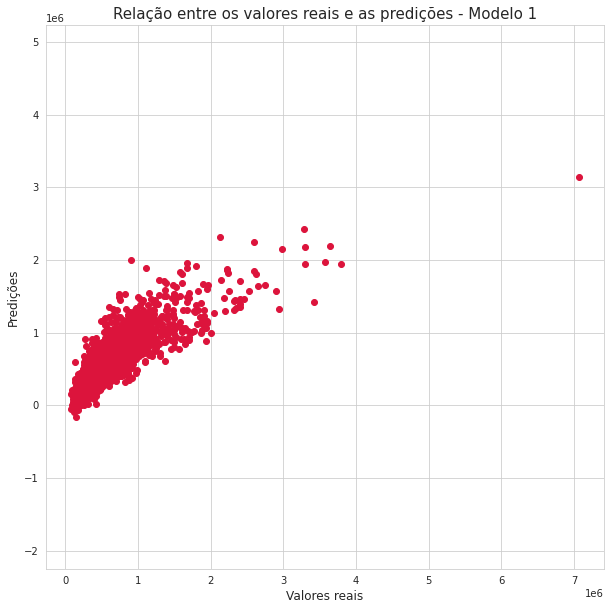



---------------------------------------- MODELO 2 ----------------------------------------

Coeficientes: 
[-9.16582388e+06 -2.64289015e+04  4.80757318e+04  9.58831936e+01
 -1.54028803e-01  1.08962661e+04  4.73962163e+05  4.73738927e+04
  2.19830240e+04  1.05112693e+05  6.79287057e+01  6.14175096e+01
 -3.01151622e+03  3.00208149e+01  5.19985492e+05  8.49002349e+04
  1.47212029e+01 -2.59579869e-01]

R2 ajustado: 0.673415



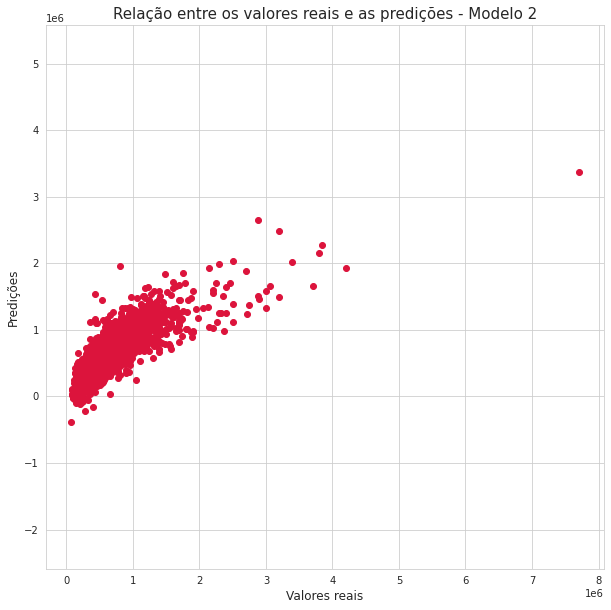



---------------------------------------- MODELO 3 ----------------------------------------

Coeficientes: 
[-9.36704501e+06 -3.01308436e+04  4.02506890e+04  9.81152858e+01
  5.12050852e-01  2.67212571e+04  6.69256500e+05  4.87116338e+04
  2.60683662e+04  1.02244658e+05  5.73608298e+01  4.31765629e+01
 -3.02145782e+03  4.12389120e+00  5.28773169e+05  8.65541503e+04
  3.22608928e+01 -8.90841558e-01]

R2 ajustado: 0.689378



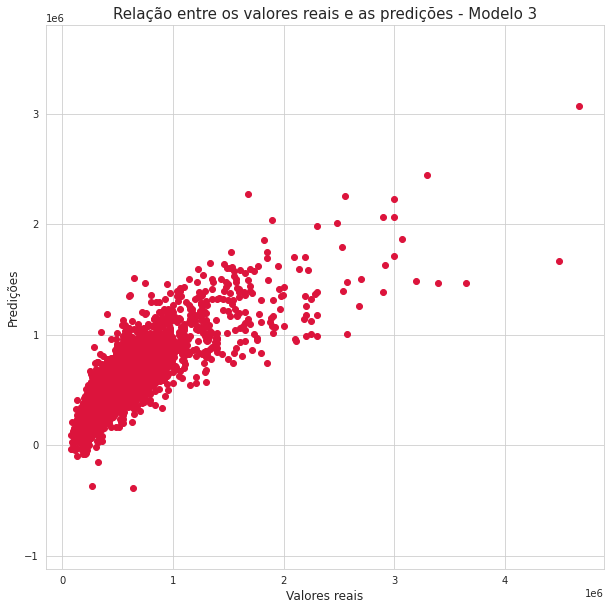



---------------------------------------- MODELO 4 ----------------------------------------

Coeficientes: 
[-9.40569479e+06 -5.31974785e+04  4.79666500e+04  1.29733353e+02
  8.06799179e-02  2.57262281e+03  6.43957310e+05  5.29212425e+04
  2.36647361e+04  1.01485080e+05  6.67678809e+01  5.40922885e+01
 -2.97210587e+03  2.31620629e-01  5.14581841e+05  8.08306688e+04
  4.15110755e+00 -3.88729690e-01]

R2 ajustado: 0.692992



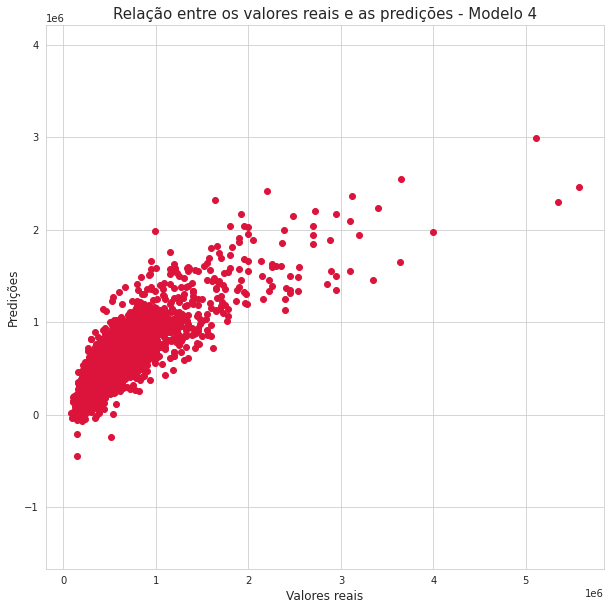



---------------------------------------- MODELO 5 ----------------------------------------

Coeficientes: 
[-8.77802448e+06 -3.72641025e+04  5.70764261e+04  8.44248779e+01
  8.30095472e-02  1.33823515e+02  5.33929694e+05  5.99047688e+04
  3.26527264e+04  1.12602963e+05  7.63540302e+01  5.79466280e+01
 -3.14211562e+03  2.06003828e+01  5.09072422e+05  8.21764114e+04
  1.78527859e+01 -7.34759691e-01]

R2 ajustado: 0.702931



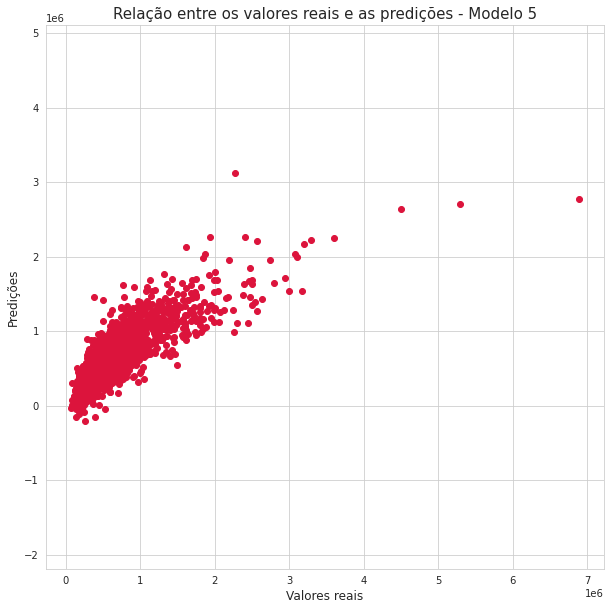



Média do R2 ajustado: 0.691667


In [9]:
r = RidgeRegression()
lista_r2aj = kfoldcv(X_houses, y_houses, 5, r, 0.01, normalize=True)

print(f'\n\nMédia do R2 ajustado: {np.round(np.mean(lista_r2aj), 6)}')

**O modelo estimado de regressão (linear) “se ajustou” bem aos dados? Justifique.**

O contexto ideal seria ter a relação entre os valores reais e as predições o mais próximo possível de uma reta. Como isso não acontece em nenhum dos modelos, podemos dizer que nenhum se ajustou muito bem aos dados (o que se comprova através do R2 ajustado). Isso pode indicar que os dados têm uma relação não-linear ou que há multicolinearidade.

### Testando a Regressão Polinomial



---------------------------------------- MODELO DE GRAU 1 ----------------------------------------

R2: 0.948173


R2 ajustado: 0.948081



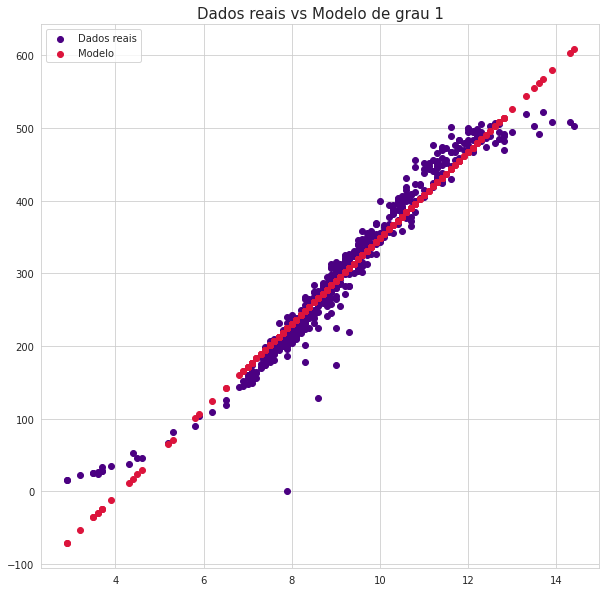



---------------------------------------- MODELO DE GRAU 2 ----------------------------------------

R2: 0.950286


R2 ajustado: 0.950197



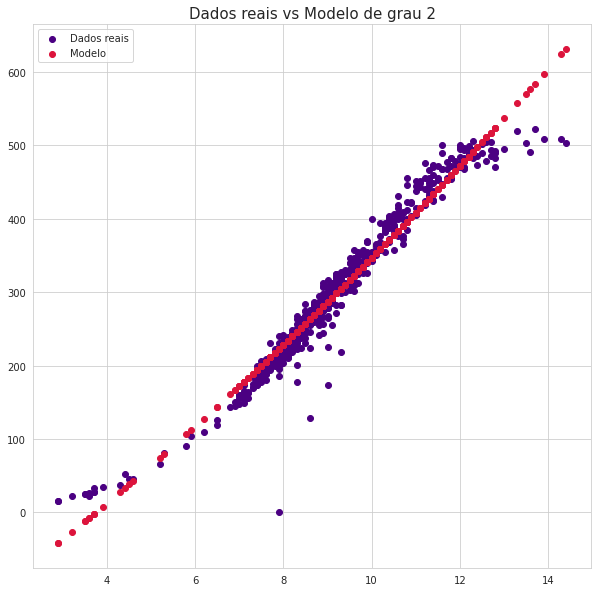



---------------------------------------- MODELO DE GRAU 3 ----------------------------------------

R2: 0.970407


R2 ajustado: 0.970354



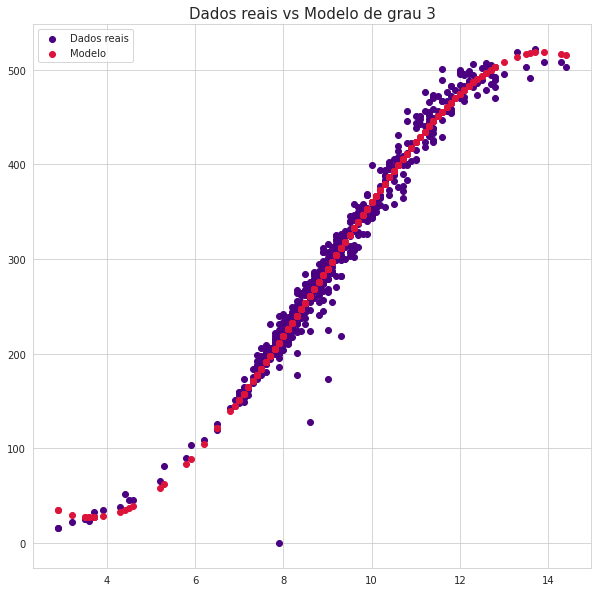



---------------------------------------- MODELO DE GRAU 4 ----------------------------------------

R2: 0.971182


R2 ajustado: 0.971131



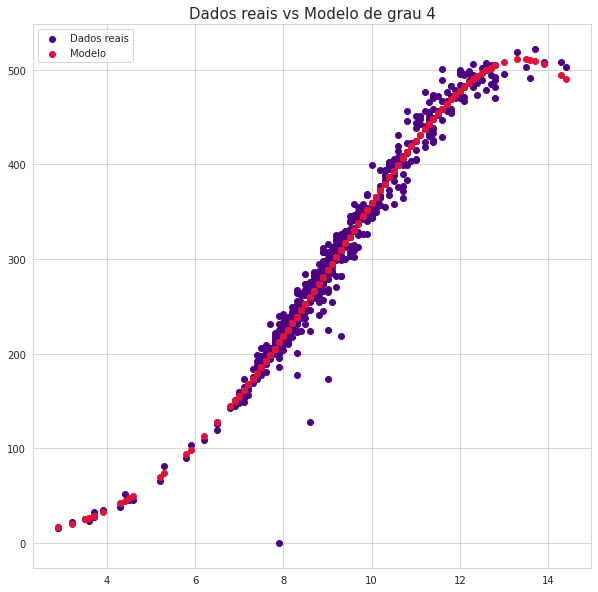



---------------------------------------- MODELO DE GRAU 5 ----------------------------------------

R2: 0.971192


R2 ajustado: 0.971141



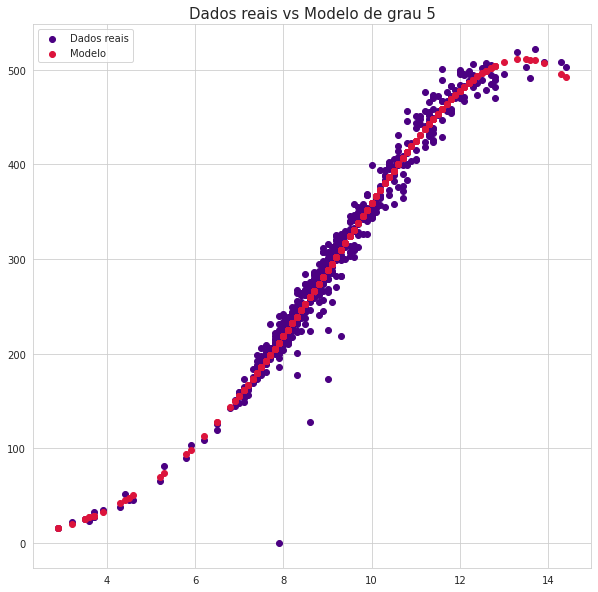

In [10]:
X_train, X_teste, y_train, y_teste = train_test_split(X_aerogerador, y_aerogerador)

for k in range(1, 6):
  p = PolynomialRegression()
  p.fit(k, 0.01)
  ypred = p.predict(X_teste, y_teste)

  r2 = np.round(r2_score(y_teste, ypred), 6)
  r2aj = r2_ajustado(r2, np.matrix(X_teste).T.shape)
  
  print(f"\n\n{'-' * 40} MODELO DE GRAU {k} {'-' * 40}")
  print(f'\nR2: {r2}\n')
  print(f'\nR2 ajustado: {r2aj}\n')

  #plotando os dados e a curva estimada pelo modelo
  plt.figure(figsize=(10,10))
  plt.scatter(X_teste, y_teste, c='indigo')
  plt.scatter(X_teste, ypred, c='crimson')

  plt.title(f'Dados reais vs Modelo de grau {k}', fontsize = 15)
  plt.legend(['Dados reais', 'Modelo'])
  plt.show()

**Qual seria o melhor valor de k para a aproximação desta curva de geração de potência? Justifique.**

Dados os polinômios testados (graus 1 a 5), considerando apenas a adequação visual da curva e os valores de R2 ajustado, k = 5 se mostra o melhor valor.

Entretanto, a partir do grau 3, ao aumentar o grau não há um aumento significativo no R2 ajustado, então caso queiramos diminuir custos de processamento, **para esse problema**, k = 3 ou 4 podem já ser suficientemente bons.
